**IMPORT IMPORTANT LIBRARIES AND TOOLS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv"
df = pd.read_csv(file_path)
df.to_csv('obesity_level_prediction.csv',index=False)

In [4]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


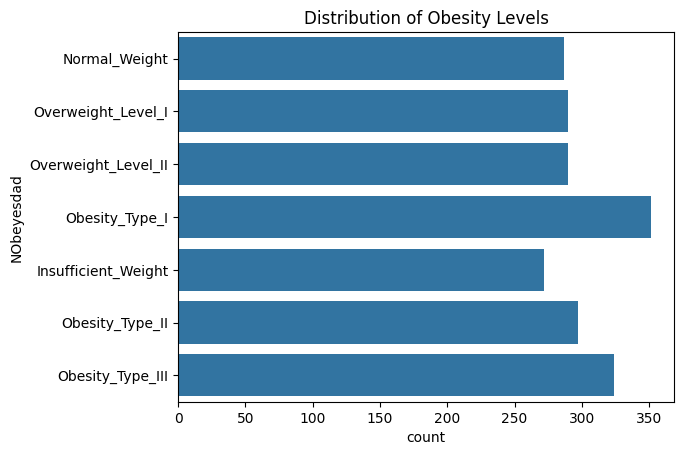

In [9]:
sns.countplot(y=df['NObeyesdad'],data=df)
plt.title('Distribution of Obesity Levels')
plt.show()

PRINT NUMBER OF NULL VALUES WITHIN THE EACH COLUMN

In [13]:
print(df.isnull().sum()) # prints the number of NULL values within each columns

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


**FEATURE SCALING - PREPROCESSING DATA**

In [15]:
contiguous_columns = df.select_dtypes(include='float64').columns.to_list()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[contiguous_columns])
scaled_df = pd.DataFrame(scaled_features,columns=scaler.get_feature_names_out(contiguous_columns))
scaled_data = pd.concat([df.drop(columns=contiguous_columns), scaled_df], axis=1)

**ONE HOT ENCODING**



In [18]:
categorical_columns = scaled_data.select_dtypes(include=['object']).columns.to_list()
categorical_columns.remove('NObeyesdad')

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_data[categorical_columns])

encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

prepared_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df], axis=1)

**ENCODE TARGET VARIABLE**

In [19]:
prepared_data['NObeyesdad']  = prepared_data['NObeyesdad'].astype('category').cat.codes
prepared_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,1,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


**SEPARATE THE INPUT AND TARGET DATA**

In [23]:
X = prepared_data.drop('NObeyesdad', axis=1)
y = prepared_data['NObeyesdad']
y.head()

,NObeyesdad
0,1
1,1
2,1
3,5
4,6


**SPLIT THE DATA**

In [33]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [34]:
model_ova = LogisticRegression(multi_class='ovr',max_iter=1000)
model_ova.fit(train_X, train_y)

LogisticRegression(max_iter=1000, multi_class='ovr')

In [35]:
y_pred_ova = model_ova.predict(test_X)
print("One vs All strategy: ")
print(f"Accuracy: {np.round(100*accuracy_score(test_y, y_pred_ova),2)}%")

One vs All strategy: 
Accuracy: 74.92%


In [36]:
model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=1000))
model_ovo.fit(train_X, train_y)

y_pred_ovo = model_ovo.predict(test_X)
print("One vs One strategy: ")
print(f"Accuracy: {np.round(100*accuracy_score(test_y, y_pred_ovo),2)}%")

One vs One strategy: 
Accuracy: 90.85%


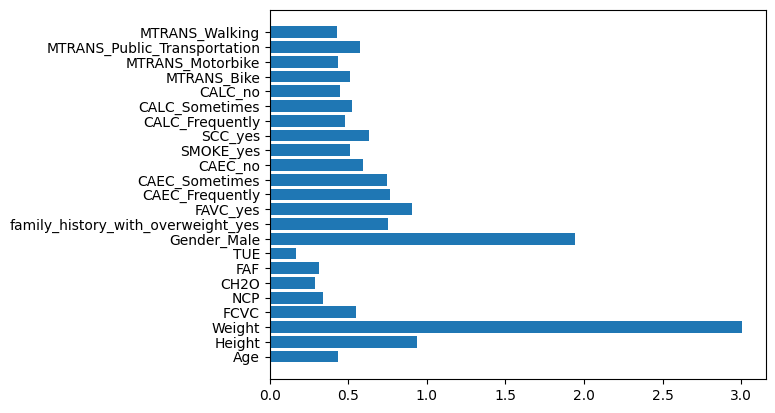

In [40]:
coef_1 = model_ova.coef_
feature_importance = np.mean(np.abs(coef_1),axis=0)
plt.barh(X.columns, feature_importance)
plt.show()

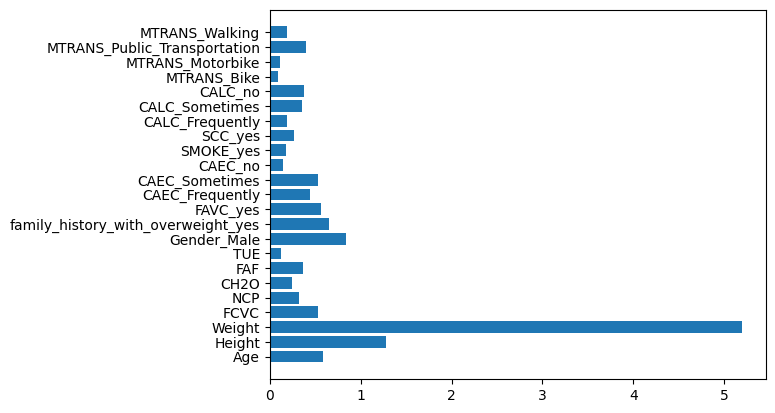

In [39]:
coef_2 = [estimator.coef_[0] for estimator in model_ovo.estimators_]
coef_2 = np.array(coef_2)
f_importance = np.mean(np.abs(coef_2),axis=0)
plt.barh(X.columns, f_importance)
plt.show()

***FINAL MODEL One vs One Method***

In [54]:
def obesity_risk_pipeline(df,test_size):
  # Check NULL values
  if(df.isnull().any().any()):
   print("There are some NULL values within the data!")
   return -1
  # Preprocessing data
  continuous_columns = df.select_dtypes(include='float64').columns.to_list()
  scaler = StandardScaler()
  scaler_features = scaler.fit_transform(df[continuous_columns])
  scaled_df = pd.DataFrame(scaler_features, columns=scaler.get_feature_names_out(continuous_columns))
  scaled_data = pd.concat([df.drop(columns=continuous_columns), scaled_df], axis=1)

  # One hot Encoding
  categorical_columns = df.select_dtypes(include=['object']).columns.to_list()
  categorical_columns.remove('NObeyesdad')
  encoder = OneHotEncoder(sparse_output=False, drop='first')
  encoded_features = encoder.fit_transform(scaled_data[categorical_columns])
  encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
  encoded_data = pd.concat([scaled_data.drop(columns=categorical_columns), encoded_df],axis=1)

  # Encode target variable
  encoded_data['NObeyesdad'] = df['NObeyesdad'].astype('category').cat.codes
  prepared_data = encoded_data

  X = prepared_data.drop('NObeyesdad', axis=1)
  y = prepared_data['NObeyesdad']

  # Split Train And Test Data
  train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = test_size, random_state = 42, stratify=y)

  # Creating the model
  model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=10000))
  model_ovo.fit(train_X, train_y)

  y_pred = model_ovo.predict(test_X)
  print(f"Accuracy: {np.round(100*accuracy_score(test_y, y_pred),6)}%")


data = pd.read_csv('obesity_level_prediction.csv')
obesity_risk_pipeline(data, 0.2)


Accuracy: 92.198582%


In [53]:
!echo $?

0
